## Algorithm

[Psuedocode for all 3 helper EEGLAB programs joint probability.](https://github.com/NeuroDataDesign/orange-panda/blob/master/notes/bad_chan_detect/eeglab-bad-electrode.pdf)

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matlab.engine
eng = matlab.engine.start_matlab()
import os
# Fix random seed
initseed = 123456789
np.random.seed(initseed)
import StringIO
out = StringIO.StringIO()

In [2]:
a = np.ones((3,4,5,6))
a = np.rollaxis(a, 3)
print a.shape
a = np.rollaxis(a, 3)
print a.shape

(6, 3, 4, 5)
(5, 6, 3, 4)


In [2]:
# Write wrapper pop_jointprob
# inEEG = C x T x N, channels x trials x timepoints, numpy array
# elecrange = range of electrodes, list/numpy array
# locthresh = threshold for individual electrode inspection
# globthresh = threshold for entire dataset inspection
def pop_jointprob(inEEG, elecrange, locthresh, globthresh):
    # first, do localized individual electrode inspection
    jp, rej = jointprob(inEEG[elecrange,:,:], locthresh, 1)
    # now reshape data for global inspection
    globEEG = np.rollaxis(inEEG, 2)
    np.reshape(globEEG, (globEEG.shape[0], globEEG.shape[1] * globEEG.shape[2]))
    # run global inspection
    jpG, rejG = jointprob(globEEG[elecrange,:,:], globthresh, 1)
    return jp, rej, jpG, rejG

# Histogram binning implementation
# D = T x N, D = data Trials, Number of timepts
# b = bins, default 1000
def realproba(D, b = 1000):
    SIZE = D.shape[0] * D.shape[1]
    P = np.zeros(b)
    P_dist = np.zeros(b)
    minimum = np.min(D)
    maximum = np.max(D)
    D = np.floor((D - minimum)/(maximum - minimum) * (b - 1)).astype(int)
    D_flat = np.ndarray.flatten(D)
    for i in range(SIZE):
        P_dist[D_flat[i]] = P_dist[D_flat[i]] + 1
    P = P_dist[D] / SIZE
    P_dist = P_dist / SIZE
    if P_dist.ndim < P.ndim:
        P_dist = np.expand_dims(P_dist, P.ndim - P_dist.ndim)
    return P, P_dist.T

This will run well with a small range of data.

For test data will just use our dataset (for now).

Also, here will import the actual MATLAB algorithm.

In [4]:
def to_matlab(arr):
    # Modify string for MATLAB processing
    test_split = str(arr).split()
    for k in range(len(test_split)):
        if test_split[k][-1:] == "]":
            test_split[k] = test_split[k] + ";"
        elif test_split[k] != "[[" and test_split[k] != "[":
            if test_split[k+1] != "]" and test_split[k+1] != "]]":
                test_split[k] = test_split[k] + ","
    newstr = ' '.join(test_split)
    return newstr

In [5]:
os.chdir("/home/nitin/hopkins/neurodata/orange-panda/notes/bad_chan_detect")
a = np.array([[2, 2, 2, 3], [2, 2, 2, 3], [2, 2, 2, 3], [2, 2, 2, 3]])
e, f = realproba(a, 6)
c, d = eng.realproba(eng.eval(str(a)), 6.0, stdout = out, nargout = 2)
print np.array_equal(e, c)
print e
print c

test_split = str(a).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","
newstr = ' '.join(test_split)
print newstr
newstr = to_matlab(a)
print newstr
c, d = eng.realproba(eng.eval(newstr), 6.0, stdout = out, nargout = 2)
print np.array_equal(e, c)
print e
print c

True
[[ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]]
[[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25]]
[[2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]];
[[2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]];
True
[[ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]]
[[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25]]


***
## Simulated Data

### To check realproba

- Make random 1D and 2D arrays:
    - 10 4x4 2D arrays, range of values 0-10, 15-25 bins
    - 10 30 1D arrays, range of values 0-50, 55-65 bins
    - 10 30 x 30 2D arrays, range of values 0-50, 55-65 bins

## Realproba Simulated Data First

In [6]:
def probdata(case):
    bins = 0
    array = []
    if case == 0:
        bins = np.floor(np.random.uniform(15, 25))
        array = np.random.uniform(0, 10, size = (4, 4))
    elif case == 1:
        bins = np.floor(np.random.uniform(50, 60))
        array = np.random.uniform(0, 50, size = (1, 30))
    else:
        bins = np.floor(np.random.uniform(50, 60))
        array = np.random.uniform(0, 50, size = (30,30))
    return array, bins
    
array = np.random.uniform(0, 50, size = (30, 30))
print array.ndim

2


Real proba data will just look like random noise

In [7]:
def eval_proba(arr1, arr2):
    return np.array_equal(np.asarray(arr1), np.asarray(arr2))

In [8]:
test = probdata(2)
test_split = str(test[0]).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","
newstr = ' '.join(test_split)
# print newstr
        
out = StringIO.StringIO()
test_prob, test_dist = eng.realproba(
            eng.eval(newstr), float(test[1]), stdout = out, nargout = 2)
# print out.getvalue()

In [9]:
test_split = str(test[0]).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","

print test_split[0]
print test_split[1]
print test_split[30]
print test_split[31]
print test_split[32]
print test_split[61]
print test_split[62]
print test_split[92]

newstr = ' '.join(test_split)
# print newstr

[[
33.45481988,
46.0673176,
];
[
32.55836417,
36.2722741,
22.19313188,


Real Proba Case 0


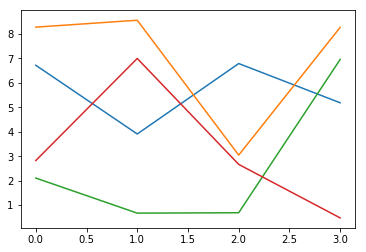

P equivalence: True
P_dist equivalence: True


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


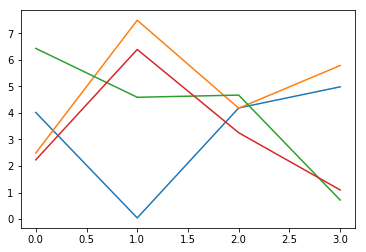

P equivalence: True
P_dist equivalence: True


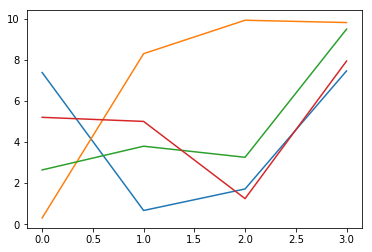

P equivalence: True
P_dist equivalence: True


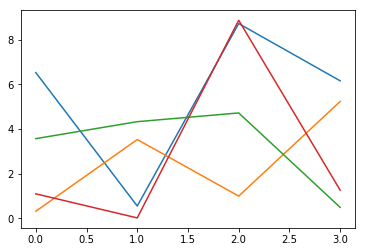

P equivalence: True
P_dist equivalence: True


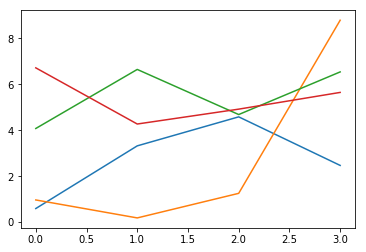

P equivalence: True
P_dist equivalence: True


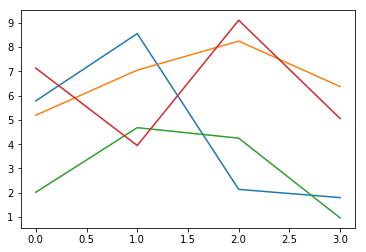

P equivalence: True
P_dist equivalence: True


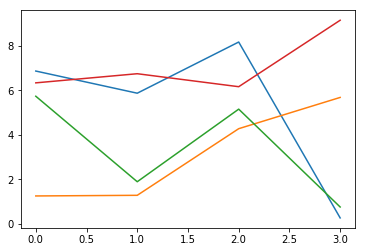

P equivalence: True
P_dist equivalence: True


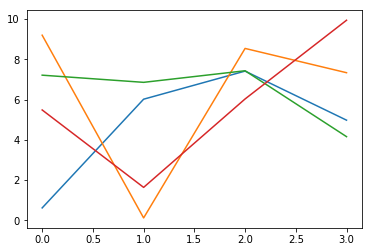

P equivalence: True
P_dist equivalence: True


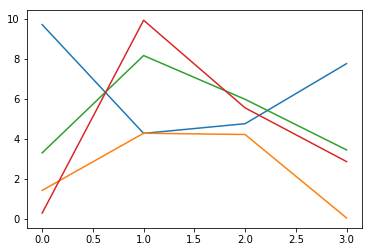

P equivalence: True
P_dist equivalence: True


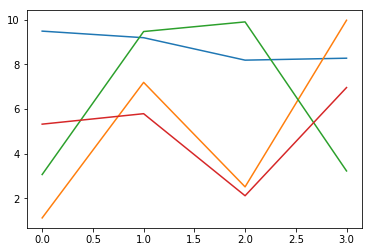

P equivalence: True
P_dist equivalence: True



Real Proba Case 1


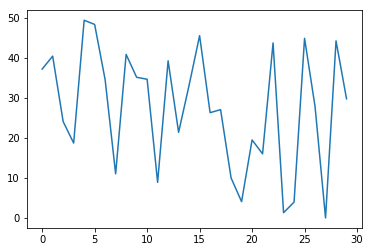

P equivalence: True
P_dist equivalence: True


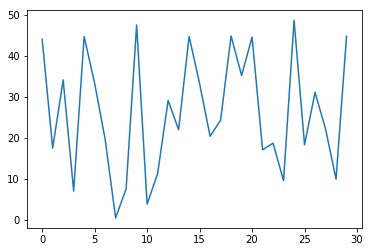

P equivalence: True
P_dist equivalence: True


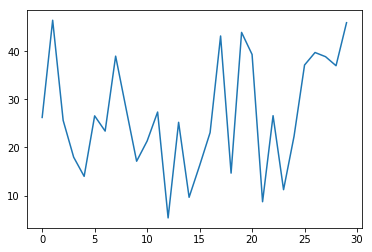

P equivalence: True
P_dist equivalence: True


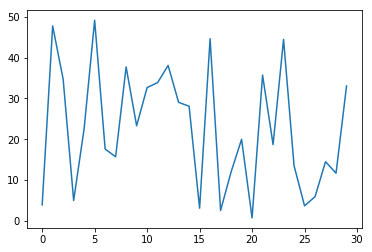

P equivalence: True
P_dist equivalence: True


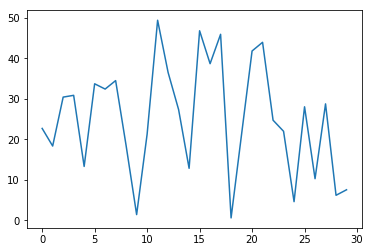

P equivalence: True
P_dist equivalence: True


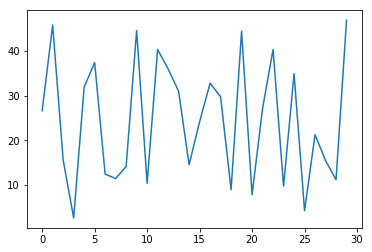

P equivalence: True
P_dist equivalence: True


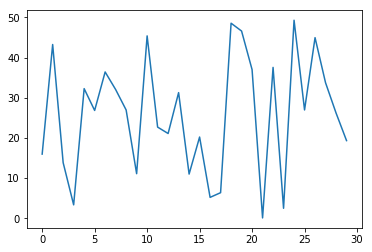

P equivalence: True
P_dist equivalence: True


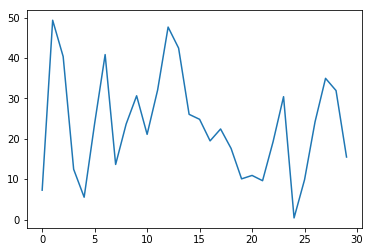

P equivalence: True
P_dist equivalence: True


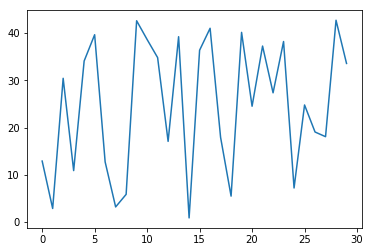

P equivalence: True
P_dist equivalence: True


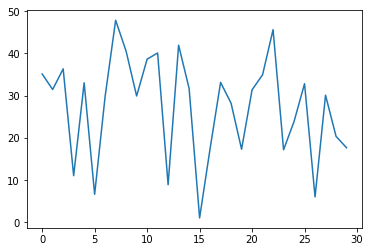

P equivalence: True
P_dist equivalence: True



Real Proba Case 2


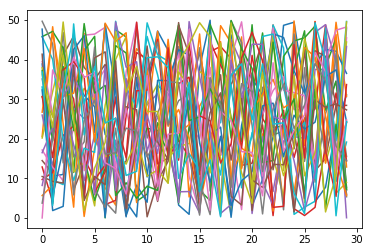

P equivalence: True
P_dist equivalence: True


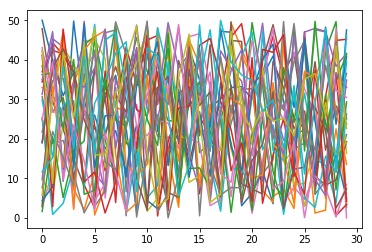

P equivalence: True
P_dist equivalence: True


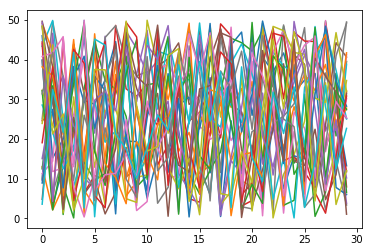

P equivalence: True
P_dist equivalence: True


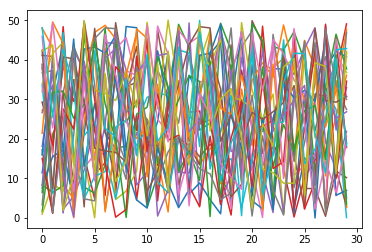

P equivalence: True
P_dist equivalence: True


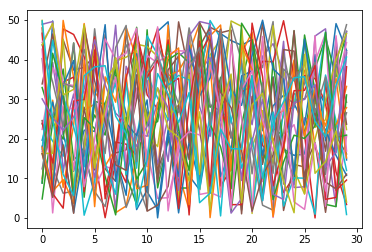

P equivalence: True
P_dist equivalence: True


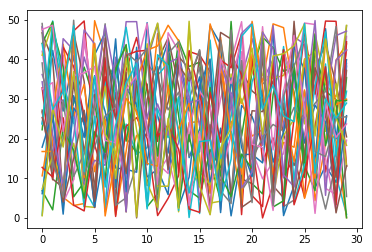

P equivalence: True
P_dist equivalence: True


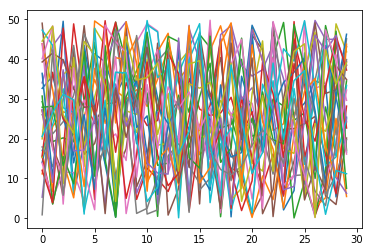

P equivalence: True
P_dist equivalence: True


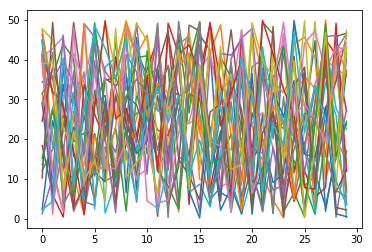

P equivalence: True
P_dist equivalence: True


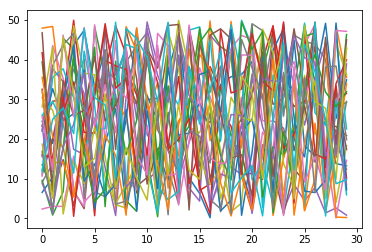

P equivalence: True
P_dist equivalence: True


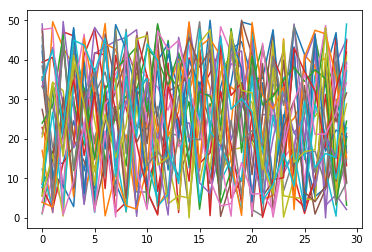

P equivalence: True
P_dist equivalence: True





In [10]:
bad_elec_probs = []
bad_dist_probs = []
for j in range(3):
    proba_case = []
    print "Real Proba Case", j
    for i in range(10):
        proba_case.append(probdata(j))
        x = range(proba_case[i][0].shape[1])
        for k in range(proba_case[i][0].shape[0]):
            plt.plot(x, proba_case[i][0][k,:])
        plt.show()
        P, P_dist = realproba(proba_case[i][0], proba_case[i][1])
        
        # Modify string for MATLAB processing
        test_split = str(proba_case[i][0]).split()
        for k in range(len(test_split)):
            if test_split[k][-1:] == "]":
                test_split[k] = test_split[k] + ";"
            elif test_split[k] != "[[" and test_split[k] != "[":
                test_split[k] = test_split[k] + ","
        newstr = ' '.join(test_split)
        #print newstr
        
        mat_P, mat_P_dist = eng.realproba(
            eng.eval(newstr), float(proba_case[i][1]), stdout = out, nargout = 2)
    #     print "MATLAB Data Norm:"
    #     print out.getvalue()
        print "P equivalence:", eval_proba(P, np.array(mat_P))
        if not eval_proba(P, np.array(mat_P)):
            bad_elec_probs.append((j, i))
    #     print "Python"
    #     print P
    #     print "MATLAB"
    #     print np.array(mat_P)
    #     print "P_dist"
    #     print P_dist
    #     print "Data"
    #     print proba_case1[i][0]
        print "P_dist equivalence:", eval_proba(P_dist, mat_P_dist)
        if not eval_proba(P_dist, mat_P_dist):
            bad_dist_probs.append((j,i))
    print
    print
    print

In [11]:
print bad_elec_probs
print bad_dist_probs
print "HOORAY!"

[]
[]
HOORAY!


**Now, will run on real data!**

In [4]:
import h5py
import os
# os.chdir("/home/nitin/hopkins/neurodata/nicolas")

# return tuple of patient info
def get_patient(filename):
    curr_wd = os.getcwd()
    os.chdir("/home/nitin/hopkins/neurodata/nicolas")
    elec_range = range(0, 110)
    # get data
    D = h5py.File(filename, 'r')
    patient = D["EEG"]["data"][:, :]
    time = D["EEG"]["times"][:]
    nic_auto_bad = D["auto_badchans"][:]
    nic_man_bad = D["man_badchans"][:]
    # get zero elecs
    zero_elec = []
    for i in range(patient.shape[1]):
        is_zero = True
        for j in range(500):
            if patient[j, i] != 0:
                is_zero = False
        if is_zero:
            zero_elec.append(i)
    
    # make it 0-indexed
    nic_auto_bad = [int(x) - 1 for x in nic_auto_bad if x != 0]
    nic_man_bad = [int(x) - 1 for x in nic_man_bad if x != 0]
    # get good electrodes
    good_elec = set(elec_range).difference(nic_auto_bad).difference(nic_man_bad).difference(zero_elec)
    os.chdir(curr_wd)
    return patient, time, nic_auto_bad, nic_man_bad, zero_elec, good_elec


In [13]:
# patient0 = gp_A00051826001.mat
patient0 = get_patient("gp_A00051826001.mat")

# define function to segregate data into separate trials
def trials(l, n):
    print l.shape[0]
    print l.shape[1]
    num = len(l)/n
    print num * n
    l = l[:(num * n),:]
    ret_arr = np.reshape(l, (n, len(l)/n, l.shape[1]))
    ret_arr = np.rollaxis(ret_arr, 2)
    return ret_arr

patient0_trials = trials(patient0[0], 4)
print patient0_trials.shape

def to_matlab_comp(mat):
    currwd = os.getcwd()
    os.chdir("/home/nitin/hopkins/neurodata/orange-panda")
    scipy.io.savemat('notes/bad_chan_detect/temp/test.mat', mdict = {"arr":mat})
    loaded_mat = eng.load(os.getcwd() + '/notes/bad_chan_detect/temp/test.mat')
    data = eng.double(loaded_mat.values()[0])
    os.chdir(currwd)
    return data

209026
111
209024
(111, 4, 52256)


In [14]:
os.chdir("/home/nitin/hopkins/neurodata/orange-panda")
test_mat, test_bins = probdata(0)
# print test_mat
scipy.io.savemat('notes/bad_chan_detect/temp/test.mat', mdict = {"arr":test_mat})
test_load_mat = eng.load(os.getcwd() + '/notes/bad_chan_detect/temp/test.mat')
# print test_load_mat.values()[0]
data = eng.double(test_load_mat.values()[0]) # d is for double, see link below on types
# print data
test_prob, test_dist = realproba(test_mat, test_bins)
mat_prob, mat_dist = eng.realproba(data, eng.double(int(test_bins)), stdout = out, nargout = 2)
print test_prob
print
print
print mat_prob
print eval_proba(test_prob, mat_prob)

[[ 0.0625  0.125   0.0625  0.0625]
 [ 0.0625  0.0625  0.0625  0.0625]
 [ 0.0625  0.125   0.0625  0.0625]
 [ 0.0625  0.0625  0.0625  0.0625]]


[[0.0625,0.125,0.0625,0.0625],[0.0625,0.0625,0.0625,0.0625],[0.0625,0.125,0.0625,0.0625],[0.0625,0.0625,0.0625,0.0625]]
True


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
print patient0_trials.shape
# get 1 electrode
patient0_1 = patient0_trials[1,:,:]
print patient0_1.shape
# get matlab version
pat0_1_mat = to_matlab_comp(patient0_1)
print type(pat0_1_mat)
# now run both
prob_1, dist_1 = realproba(patient0_1, 1000)
mat_prob_1, mat_dist_1 = eng.realproba(pat0_1_mat, 1000.0, stdout = out, nargout = 2)

(111, 4, 52256)
(4, 52256)
<class 'matlab.mlarray.double'>


In [16]:
# print prob_1[0,:].shape
# print np.asarray(mat_prob_1)[0,:].shape
prob_diff = prob_1[0,:] - np.asarray(mat_prob_1)[0,:]
prob_non_diff = np.nonzero(prob_diff)[0]
print "Nonzero Difference:", prob_non_diff
print "Amount of nonzero difference:", len(prob_non_diff)
print 56
print prob_1[0,56]
print np.asarray(mat_prob_1)[0,56]
print prob_diff[56]
print 51989
print prob_1[0,51989]
print np.asarray(mat_prob_1)[0,51989]
print prob_diff[51989]
print 76
print prob_1[0,76]
print np.asarray(mat_prob_1)[0,76]
print prob_diff[76]

diff_err = []
same_err = []
for i in prob_non_diff:
    if np.isclose(abs(prob_diff[i]), prob_diff[56], atol=1e-10):
        same_err.append(i)
    else:
        diff_err.append(i)
print "Diff:", len(diff_err)
print "Same:", len(same_err)
print prob_diff[diff_err]


# print eval_proba(prob_1[0,:], np.asarray(mat_prob_1)[0,:])
print eval_proba(dist_1[0,:], np.asarray(mat_dist_1)[0,:])

Nonzero Difference: [   56    76   180 ..., 51989 52167 52222]
Amount of nonzero difference: 1400
56
0.00440619259032
0.0044014084507
4.78413962033e-06
51989
0.00440619259032
0.0044014084507
4.78413962033e-06
76
0.00449230710349
0.00449709124311
-4.78413962033e-06
Diff: 2
Same: 1398
[  1.48308328e-04   9.08986528e-05]
False


In [17]:
prob_diff = prob_1[1,:] - np.asarray(mat_prob_1)[1,:]
prob_non_diff = np.nonzero(prob_diff)[0]
print "Nonzero Difference:", prob_non_diff
print "Amount of nonzero difference:", len(prob_non_diff)
print 62
print prob_1[1,62]
print np.asarray(mat_prob_1)[1,62]
print prob_diff[62]
print 52141
print prob_1[1,52141]
print np.asarray(mat_prob_1)[1,52141]
print prob_diff[52141]
print 76
print prob_1[1,92]
print np.asarray(mat_prob_1)[1,92]
print prob_diff[92]

diff_err = []
same_err = []
for i in prob_non_diff:
    if np.isclose(abs(prob_diff[i]), abs(prob_diff[62]), atol=1e-10):
        same_err.append(i)
    else:
        diff_err.append(i)
print "Diff:", len(diff_err)
print "Same:", len(same_err)
print prob_diff[diff_err]


# print eval_proba(prob_1[0,:], np.asarray(mat_prob_1)[0,:])

Nonzero Difference: [   62    92   120 ..., 52141 52179 52242]
Amount of nonzero difference: 1396
62
0.00425310012247
0.00425788426209
-4.78413962033e-06
52141
0.00268390232701
0.00267911818739
4.78413962033e-06
76
0.00425310012247
0.00425788426209
-4.78413962033e-06
Diff: 1
Same: 1395
[-0.00012917]


In [18]:
# Will see if thresholding gets messed up
# because of the slight differences
pat0_test = patient0_trials[1:4,:,:]
pat0_test_mat = to_matlab_comp(pat0_test)
print pat0_test.shape
print np.asarray(pat0_test_mat).shape

(3, 4, 52256)
(3, 4, 52256)


In [19]:
# now run both test sets, collect joint probs
py_prob = []
mat_prob = []
for i in range(pat0_test.shape[0]):
    py_prob.append(np.log(realproba(pat0_test[i,:,:], 1000)[0]))
    mat_prob.append(np.log(eng.realproba(to_matlab_comp(pat0_test[i,:,:]), 1000.0, stdout = out, nargout = 1)))

py_prob = np.asarray(py_prob)
mat_prob = np.asarray(mat_prob)

py_prob = -np.sum(py_prob, axis=2)
mat_prob = -np.sum(mat_prob, axis=2)
print py_prob.shape
print mat_prob.shape

(3, 4)
(3, 4)


In [20]:
print py_prob
print
print mat_prob

[[ 310865.95212944  308781.64578643  310840.63345638  312534.99150142]
 [ 302038.07471765  302299.76778987  305478.72305481  305894.00647584]
 [ 298638.88472098  298492.64045249  301894.08500642  302506.99140885]]

[[ 310865.92014217  308781.5597163   310840.72548168  312535.11306153]
 [ 302038.16509743  302299.7194412   305478.48935733  305894.0428437 ]
 [ 298638.79181995  298492.80161353  301894.0757224   302506.96115188]]


In [21]:
py_mean = np.mean(py_prob, axis=1, keepdims=True)
py_std = np.std(py_prob, axis=1, keepdims=True)
test_ones = np.ones(py_prob.shape)
py_norm = np.divide(py_prob - py_mean * test_ones, py_std)
print py_norm

[[ 0.08277862 -1.48364553  0.06375081  1.3371161 ]
 [-1.06920577 -0.92112764  0.87767335  1.11266005]
 [-0.95263467 -1.03250632  0.82520038  1.15994061]]


In [22]:
mat_mean = np.mean(mat_prob, axis=1, keepdims=True)
mat_std = np.std(mat_prob, axis=1, keepdims=True)
test_ones = np.ones(mat_prob.shape)
mat_norm = np.divide(mat_prob - mat_mean * test_ones, mat_std)
print mat_norm

[[ 0.08273207 -1.48364636  0.0637985   1.33711579]
 [-1.06916544 -0.92116127  0.87758999  1.11273672]
 [-0.95270503 -1.03243923  0.82520498  1.15993927]]


In [23]:
thresh = np.linspace(1,3,num=21)
py_rej = []
mat_rej = []
diff_rej = []
for i in thresh:
    py_curr = abs(py_norm) > i
    mat_curr = abs(mat_norm) > i
    py_rej.append(py_curr)
    mat_rej.append(mat_curr)
    if not np.array_equal(py_curr, mat_curr):
        diff_rej.append(i)
# print py_rej
# print mat_rej
print diff_rej

[]


In [20]:
# define function to segregate data into separate trials
def trials(l, n):
    num = len(l)/n
    l = l[:(num * n),:]
    ret_arr = np.reshape(l, (n, len(l)/n, l.shape[1]))
    ret_arr = np.rollaxis(ret_arr, 2)
    return ret_arr

patient0_trials = trials(patient0[0], 4)
# patient, zero = list(get_patient("gp_A00051826001.mat")[i] for i in [0, 4])

In [21]:
def compare_data_help(data):
    # set bins
    bins = 1000
    # get joint probs
    py_prob = []
    mat_prob = []
    for i in range(data.shape[0]):
        py_prob.append(realproba(data[i,:,:], bins)[0])
        mat_prob.append(eng.realproba(to_matlab_comp(data[i,:,:]), eng.double(int(bins)), stdout = out, nargout = 1))
    print "Python realproba executed"
    py_prob = np.asarray(py_prob)
    print py_prob.shape
    print "MATLAB realproba executed"
    mat_prob = np.asarray(mat_prob)
    print mat_prob.shape
    # now run both test sets, collect joint probs with log transform
    py_prob = np.log(py_prob)
    mat_prob = np.log(mat_prob)
    print "Data log transformed"
    # sum logs of likelihoods
    py_prob = -np.sum(py_prob, axis=2)
    mat_prob = -np.sum(mat_prob, axis=2)
    print "Logs summed"
    print py_prob
    print
    print mat_prob
    # normalize data
    test_ones = np.ones(py_prob.shape)
    py_mean = np.mean(py_prob, axis=1, keepdims=True)
    py_std = np.std(py_prob, axis=1, keepdims=True)
    py_norm = np.divide(py_prob - py_mean * test_ones, py_std)
    mat_mean = np.mean(mat_prob, axis=1, keepdims=True)
    mat_std = np.std(mat_prob, axis=1, keepdims=True)
    mat_norm = np.divide(mat_prob - mat_mean * test_ones, mat_std)
    print "Data normed"
    print py_norm
    print
    print mat_norm
    # threshold data
    thresh = np.linspace(1,3,num=21)
    py_rej = []
    mat_rej = []
    diff_rej = []
    for i in thresh:
        py_curr = abs(py_norm) > i
        mat_curr = abs(mat_norm) > i
        py_rej.append(py_curr)
        mat_rej.append(mat_curr)
        if not np.array_equal(py_curr, mat_curr):
            diff_rej.append(i)
    return py_rej, mat_rej, diff_rej

In [22]:
# reshape data with trials
num_trials = 4
data = trials(patient0[0], num_trials)
data = data[1:4,:,:]
py_orig, mat_orig, diff_orig = compare_data_help(data)

Python realproba executed
(3, 4, 52256)
MATLAB realproba executed
(3, 4, 52256)
Data log transformed
Logs summed
[[ 310865.95212944  308781.64578643  310840.63345638  312534.99150142]
 [ 302038.07471765  302299.76778987  305478.72305481  305894.00647584]
 [ 298638.88472098  298492.64045249  301894.08500642  302506.99140885]]

[[ 310865.92014217  308781.5597163   310840.72548168  312535.11306153]
 [ 302038.16509743  302299.7194412   305478.48935733  305894.0428437 ]
 [ 298638.79181995  298492.80161353  301894.0757224   302506.96115188]]
Data normed
[[ 0.08277862 -1.48364553  0.06375081  1.3371161 ]
 [-1.06920577 -0.92112764  0.87767335  1.11266005]
 [-0.95263467 -1.03250632  0.82520038  1.15994061]]

[[ 0.08273207 -1.48364636  0.0637985   1.33711579]
 [-1.06916544 -0.92116127  0.87758999  1.11273672]
 [-0.95270503 -1.03243923  0.82520498  1.15993927]]


In [23]:
def compare_data(filename):
    # set dir
    curr_dir = os.getcwd()
    os.chdir("/home/nitin/hopkins/neurodata/orange-panda")
    print "Set dir"
    # get patient data
    patient, zero = list(get_patient(filename)[i] for i in [0, 4])
    print "Have patient data"
    # get rid of 0 electrodes
    data = patient[:, list(set(range(111)) - set(zero))]
    print "Removed 0's"
    # reshape data with trials
    num_trials = 4
    data = trials(data, num_trials)
    print "Gotten trials"
    return compare_data_help(data)

In [ ]:
py_test, mat_test, diff_test = compare_data("gp_A00051826001.mat")

Set dir
Have patient data
Removed 0's
Gotten trials


In [ ]:
print diff_test

In [ ]:
# List all patient names
patient_names = [
    "bip_A00053375001",
    "gip_A00051955001",
    "gip_A00053440001"
]

In [42]:
diff_fin = []
for name in patient_names:
    print name
    py_rej, mat_rej, diff_rej = compare_data(name + ".mat")
    if diff_rej:
        diff_fin.append((name, py_rej, mat_rej, diff_rej))
    print

bip_A00053375001
Set dir
Have patient data
Removed 0's
Gotten trials
Python realproba executed
(108, 4, 32837)
MATLAB realproba executed
(108, 4, 32837)
Data log transformed
Logs summed
[[ 183946.24799358  185079.15476356  187161.45169744  185470.53866515]
 [ 184972.81841615  185595.40646515  188129.4875894   186072.53853958]
 [ 184797.00059687  185540.37309732  188084.60038114  186086.18392126]
 [ 189541.58224458  189496.58585317  192262.04443607  191142.37705071]
 [ 192078.06787796  191107.17094836  193309.75336308  191937.79531145]
 [ 186901.78575574  186699.89377567  188227.7470184   187801.29705585]
 [ 191512.05195382  193371.4842115   192097.76452351  193112.34271701]
 [ 184718.73330651  185587.55228336  188049.26702174  186507.60858421]
 [ 190439.90601509  191333.66498554  193010.47052343  191968.80246188]
 [ 189072.88479063  188143.01483024  190871.22914105  189572.5698335 ]
 [ 187663.16683078  187008.15214119  188443.32043919  188174.59414674]
 [ 200923.15609223  201522.742789

In [44]:
print diff_fin

[]


Based off of these 4 patients, this should work. Will test further with the jointprob and pop_jointprob implementations.

***
### To check jointprob and pop_jointprob

**For all sine waves created:** make sure number of points = 1000 sampled from each wave representing data.

***Success:***
- 50 sine waves, all same frequency but different amplitudes
    - Should result in none selected
- 50 sine waves, different frequency all same amplitudes
    - Should result in none selected
- 50 sine waves, all same frequency but different amplitudes, 1 with lots of white noise
    - Should result in white noise one selected
- 50 sine waves, all different frequency but same amplitudes, 1 with lots of white noise
    - Should result in white noise one selected
- 50 sine waves, all same frequency but different amplitudes, 6-7 with white noise
    - Should result in white noise one selected

***Hopeful:***
- 40 sine waves, 32 with slight noise, 8 with heavy noise **CLOSEST TO REAL DATA**

***Fail:***
- 50 sine waves, all same frequency but different amplitudes, 40 with white noise
    - No idea result; either none selected or multiple


In [6]:
# Write next level wrapper, jointprob
# Joint prob can use different prob functions to get the distribution
# S = C x T x N, channels x trials x timepoints, numpy array
# OR
# S = N x (C x T), timepoints x (channels x trials), numpy array
# OR
# S = (N x C x T), straight vector of all timepoints, numpy array
# thresholds
# norm = choose normalization: 0 = none, 1 = normalize entropy, 2 = 20% trim
# thresh = threshold
def jointprob(S, thresh, oldjp, normalize, discret = 1000):
    # get num chans and trials and time
    channels = 0
    trials = 0
    timepts = 0
    if S.ndim == 1 or S.ndim == 2:
        timepts = S.shape[0]
    elif S.ndim == 3:
        channels = S.shape[0]
        trials = S.shape[1]
        timepts = S.shape[2]
    else:
        print "Bad dimensions"
        return
    # Get Joint Probs
    jp = np.zeros((channels, trials))
    if oldjp.size:
        jp = oldjp
    else:
        jp = []
        for c in range(channels):
            tmp, dist = realproba(S[c,:,:], discret)
            jp.append(np.log(tmp))
        jp = np.asarray(jp)
        jp = -np.sum(jp, axis=2)    
#     print jp
    unnormjp = jp
    # Normalize data
    if normalize:
        tmpjp = jp
        if normalize == 2:
            tmpjp = sort(jp);
            totrim = round(len(tmpjp) * 0.1)
            tmpjp = tmpjp[totrim : -totrim]
        if S.ndim == 2:
            jp = (jp - np.mean(tmpjp)) / np.std(tmpjp)
        elif S.ndim == 3:
            ones = np.ones(jp.shape)
            mean = np.mean(jp, axis=1, keepdims=True)
            std = np.std(jp, axis=1, keepdims=True)
#             print jp
#             print mean
#             print std
            jp = np.divide(jp - mean * ones, std)
    # Reject bad elecs
    rej = []
    for i in thresh:
#         print abs(jp) > i
        rej.append(abs(jp) > i)
    return jp, np.asarray(rej)

In [7]:
# Then define the general sine wave used throughout
def get_sin(chans, trials, tovary = 0):
    numvals = 1000
    # First, build the relevant linspace to grab 1000 points
    times = np.linspace(0, 1, numvals)
    wave = np.zeros((chans, trials, numvals))
    for i in range(chans):
        if tovary == 0:
            wave[i,:,:] = [np.random.uniform(.1, 6) * np.sin(2 * np.pi * times)] * trials
        elif tovary == 1:
            wave[i,:,:] = [np.sin(np.random.uniform(.1, 6) * 2 * np.pi * times)] * trials
        else:
            wave[i,:,:] = [np.random.uniform(.1, 6) * np.sin(np.random.uniform(.1, 6) * 2 * np.pi * times)] * trials
    return wave

# Define function for white noise
def gen_whitenoise(mean, std, size):
    retval = np.random.normal(mean, std, size=size)
    return retval

# Success Case 1 Data
# 50 sine waves, all same frequency but different amplitudes
def success1():
    bins = np.floor(np.random.uniform(15, 25))
    return get_sin(50, 10, 0), bins, []

# Success Case 2 Data
# 50 sine waves, different frequency all same amplitudes
def success2():
    bins = np.floor(np.random.uniform(15, 25))
    return get_sin(50, 10, 1), bins, []

# Success Case 3 Data
# 50 sine waves, all same frequency but different amplitudes, 1 with white noise
def success3():
    num_chans = 50
    num_trials = 10
    bins = np.floor(np.random.uniform(15, 25))
    bad_wn = []
    for i in range(num_trials):
        bad_wn.append(gen_whitenoise(0, 8, 1000))
    reg_wn = []
    for i in range(num_trials):
        reg_wn.append(gen_whitenoise(0, 1, 1000))
    badelec = np.floor(np.random.uniform(0, 50))
    toret = get_sin(num_chans, num_trials, 0)
    for i in range(num_chans):
        if i == badelec:
            toret[i, :] = toret[i, :] + bad_wn[:]
        else:
            toret[i, :] = toret[i, :] + reg_wn[:]
    return toret, bins, [badelec]
#print success2[0]

# # Success Case 3 Data
# # 50 different amplitude sine waves, 1 with white noise
# success3 = np.column_stack([sin] * 10 +
#                            [sin * 2] * 10 +
#                            [sin * 3] * 10 +
#                            [sin * 4] * 10 +
#                            [sin * 5] * 10)
# success3[:, 49] = success3[:, 49] + wn.T

(50, 10, 1000)


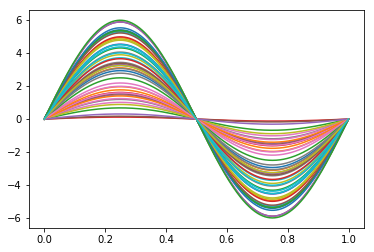

(50, 10, 1000)


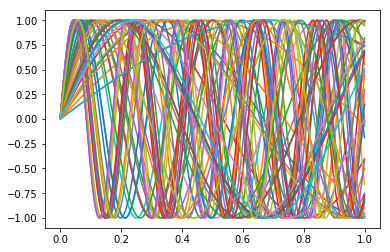

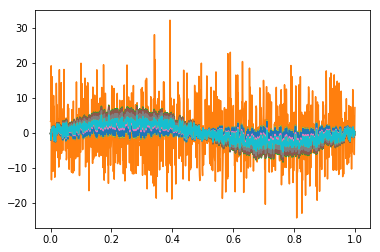

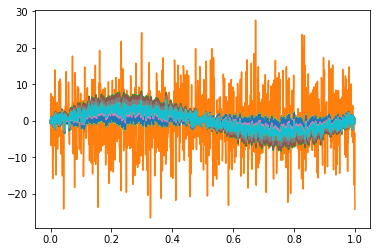

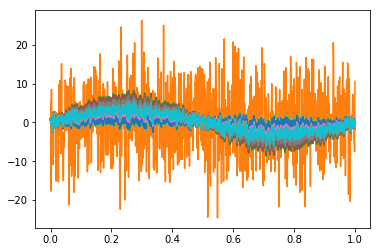

In [8]:
test_dat = success1()
print test_dat[0].shape
for i in range(50):
    plt.plot(np.linspace(0,1,1000), test_dat[0][i,0,:])
plt.show()
test_dat = success2()
print test_dat[0].shape
for i in range(50):
    plt.plot(np.linspace(0,1,1000), test_dat[0][i,0,:])
plt.show()
test_dat = success3()
for j in range(3):
    for i in range(50):
        plt.plot(np.linspace(0,1,1000), test_dat[0][i,j,:])
    plt.show()

In [22]:
# test_jp is the jp for the test data currently using
jp, rej = jointprob(patient0_trials[1:4,:,:], [1, 1.5, 2, 2.5, 3], np.asarray([]), 1000)

In [23]:
print jp
print rej

[[ 0.08277862 -1.48364553  0.06375081  1.3371161 ]
 [-1.06920577 -0.92112764  0.87767335  1.11266005]
 [-0.95263467 -1.03250632  0.82520038  1.15994061]]
[[[False  True False  True]
  [ True False False  True]
  [False  True False  True]]

 [[False False False False]
  [False False False False]
  [False False False False]]

 [[False False False False]
  [False False False False]
  [False False False False]]

 [[False False False False]
  [False False False False]
  [False False False False]]

 [[False False False False]
  [False False False False]
  [False False False False]]]


In [24]:
test_dat = success1()

In [25]:
out = StringIO.StringIO()
mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)

In [26]:
# print out.getvalue()
print np.asarray(mat_jp).shape
print mat_jp

(50, 10)
[[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan],[nan,nan,nan,nan,nan,nan

In [27]:
py_jp, py_rej = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)

In [28]:
mat_rej = np.asarray(mat_rej)
print mat_rej.shape
print py_rej.shape
print np.any(mat_rej)
print np.any(py_rej)

(50, 10)
(1, 50, 10)
False
False


**Now, while we now know that the resulting MATLAB one should always be NAN and python should 1 or -1 (both indicative of issues anyways) because the std is tiny because the data values are all predictable and perfect, we can check for that behavior for consistency.**

In [29]:
test_dat = success2()
mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)
py_jp, py_rej = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)
mat_jp = np.asarray(mat_jp)
mat_rej = np.asarray(mat_rej)

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in divide
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in greater


In [30]:
print py_jp.shape == mat_jp.shape
print py_jp[0:5,:]
print mat_jp[0:5,:]
print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))

True
[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [ 0.9486833  0.9486833  0.9486833  0.9486833  0.9486833  0.9486833
   0.9486833  0.9486833  0.9486833  0.9486833]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]]
False


Same issue... :(

In [31]:
out = StringIO.StringIO()
test_dat = success3()
mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)
py_jp, py_rej = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)
mat_jp = np.asarray(mat_jp)
mat_rej = np.asarray(mat_rej)

In [32]:
print "Shapes Equal?:", py_jp.shape == mat_jp.shape
print "Python head"
print py_jp[0:5,:]
print "MATLAB Head"
print mat_jp[0:5,:]
print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))
print "MATLAB has any NaNs?:", np.isnan(mat_jp).any()
print "Python vals bad elec"
print py_jp[test_dat[2][0]]
print "MATLAB vals bad elec"
print mat_jp[test_dat[2][0]]
print "Python has any NaNs?:", np.isnan(py_jp).any()
print "Arrays close (.1) tolerance?", np.isclose(py_jp, mat_jp, atol=.1).all()

Shapes Equal?: True
Python head
[[-0.46421199 -0.64963557  1.12867501  1.79419439  0.60094483 -1.39151944
  -0.62365671 -1.25395222  0.08204971  0.77711198]
 [ 1.14487716 -1.08919477 -0.12587314  1.44703848 -1.02450812 -0.5346872
  -1.33585448 -0.47198431  0.8080878   1.1820986 ]
 [ 0.78071488 -0.78157874  0.01471063  0.02022065 -0.44564563 -1.42041766
  -1.22576232 -0.08965657  1.79637967  1.35103509]
 [ 0.06419654 -0.14486145  0.38575896  2.30336638 -1.00916102  0.06051467
  -1.69168204 -0.37719591  0.65773597 -0.2486721 ]
 [ 0.40515171 -1.77403126  0.27244457  0.18638469 -0.32387559 -0.11138851
  -1.37073492 -0.22492807  1.79314662  1.14783076]]
MATLAB Head
[[-0.44039017 -0.61629841  1.07075513  1.70212225  0.57010632 -1.32011125
  -0.5916527  -1.18960352  0.07783919  0.73723316]
 [ 1.08612584 -1.03330089 -0.11941375  1.37278123 -0.97193374 -0.50724881
  -1.26730283 -0.44776363  0.76661939  1.1214372 ]
 [ 0.74065117 -0.74147069  0.01395573  0.01918299 -0.42277656 -1.34752651
  -1.16

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [33]:
print np.array_equal(py_rej, mat_rej)
rej_differences = np.logical_xor(py_rej, mat_rej)
rej_locs = np.where(np.any(rej_differences))
print mat_rej[test_dat[2]]
print rej_differences[0][test_dat[2]]
print np.min(abs(py_jp))
# print py_jp - mat_jp

False
[[False False False  True False False False False  True False]]
[[False False False False False False False False False False]]
0.00872805657205


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


This seems pretty bad tbh. A lot of differences in rejected trials.

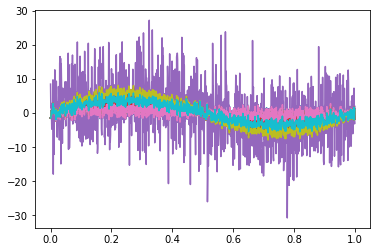

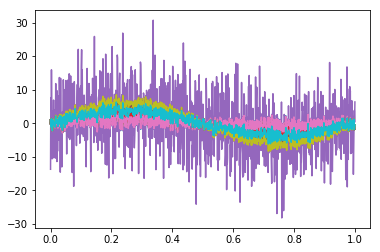

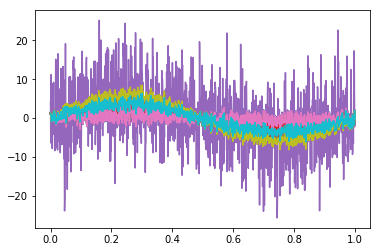

Shapes Equal?: True
Python head
[[ 0.86264319  0.77571367  0.05061166  0.05291842 -0.15088608 -1.01951516
  -0.59125782  2.05866987 -0.34109942 -1.69779831]
 [ 0.22406024 -0.15180827 -0.58267228  0.44561226 -0.50159405 -0.92353352
  -0.19367694  2.3638679   0.76155453 -1.44180988]]
MATLAB Head
[[ 0.81837518  0.7359066   0.04801444  0.05020282 -0.14314311 -0.96719701
  -0.56091642  1.95302572 -0.32359533 -1.6106729 ]
 [ 0.21256221 -0.14401797 -0.55277146  0.42274491 -0.4758539  -0.87614083
  -0.18373808  2.24256199  0.72247407 -1.36782095]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: False
All electrode/trial rejections the same?: False


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


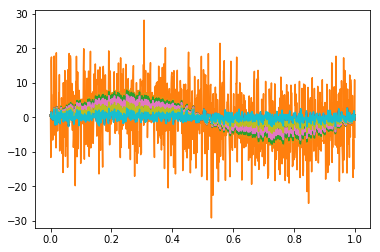

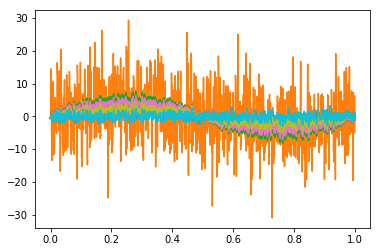

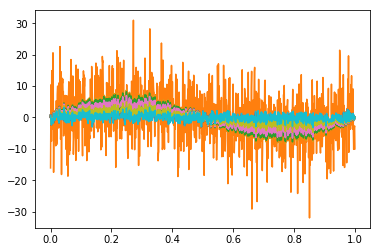

Shapes Equal?: True
Python head
[[-0.65180279 -0.20516132  0.67771988 -0.46204658 -2.49916227  1.24264925
   0.4776025   0.30316367  0.3071401   0.80989755]
 [ 0.1932859   0.31051102  0.62129638 -1.44023485 -2.05693747  0.06118553
   1.13163069 -0.43562129  0.36195177  1.25293233]]
MATLAB Head
[[-0.61835442 -0.19463312  0.64294153 -0.43833588 -2.3709135   1.17888059
   0.45309352  0.28760631  0.29137868  0.76833628]
 [ 0.1833671   0.29457662  0.5894135  -1.36632675 -1.95138222  0.05804569
   1.07355914 -0.41326664  0.3433776   1.18863597]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: False
All electrode/trial rejections the same?: False


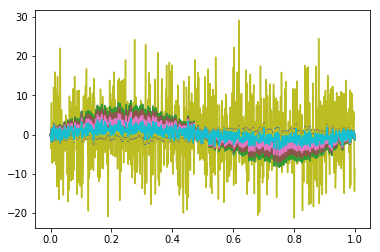

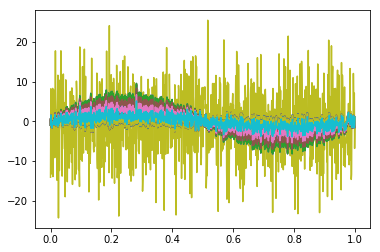

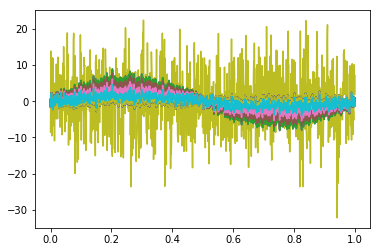

Shapes Equal?: True
Python head
[[-0.03011965 -0.16153246 -0.95968584 -0.94037052 -0.77084814 -0.24655434
   2.5083084   0.50552221 -0.64554366  0.740824  ]
 [-0.67686711  1.20374588 -0.16289251 -1.65158106 -1.03953107 -0.76264708
   1.46724381  0.37717848  0.07230262  1.17304804]]
MATLAB Head
[[-0.02857401 -0.15324315 -0.91043793 -0.8921138  -0.73129075 -0.23390199
   2.37959029  0.47958048 -0.61241649  0.70280735]
 [-0.64213252  1.14197361 -0.15453341 -1.56682737 -0.98618576 -0.72351055
   1.3919497   0.35782293  0.06859229  1.11285109]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


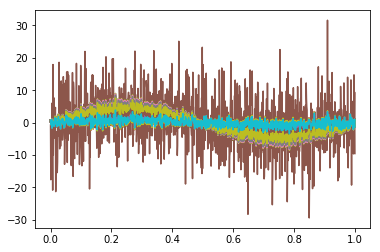

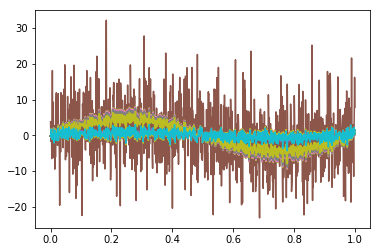

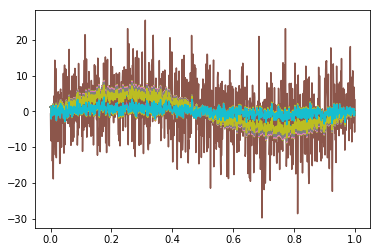

Shapes Equal?: True
Python head
[[-0.19539434  0.55523592  2.13518455 -1.70647854 -0.05612978 -0.27111243
   0.40986876  0.72340985 -1.06481426 -0.52976973]
 [-0.29237322  0.37353544  1.05818323 -1.24804434 -1.04691016  0.49048685
  -0.00733039  1.99117413 -1.34005274  0.0213312 ]]
MATLAB Head
[[-0.18536735  0.52674304  2.02561392 -1.61890769 -0.05324939 -0.25719983
   0.38883564  0.68628685 -1.0101715  -0.50258369]
 [-0.27736959  0.35436684  1.00388076 -1.18399882 -0.99318618  0.46531668
  -0.00695422  1.88899364 -1.27128565  0.02023655]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


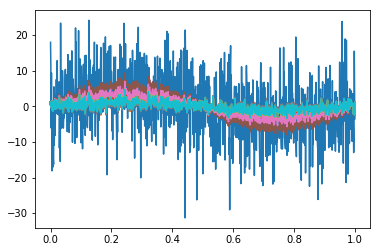

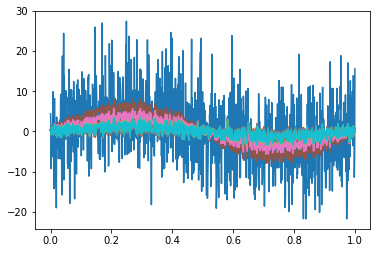

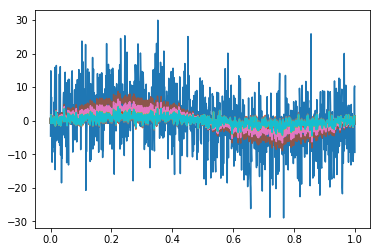

Shapes Equal?: True
Python head
[[-0.31652934 -0.28830043  1.68048936 -1.10751076  0.78114542 -1.19112548
   0.65074506 -0.39885144  1.34726862 -1.15733101]
 [-0.29260816 -0.07657393  1.00887065  0.40096044 -0.28669329 -1.36688514
   0.44096406  0.61427565  1.52666587 -1.96897614]]
MATLAB Head
[[-0.3002861  -0.2735058   1.59425219 -1.05067696  0.74105962 -1.13000085
   0.61735097 -0.3783837   1.27813123 -1.0979406 ]
 [-0.27759248 -0.07264441  0.95709873  0.38038447 -0.27198114 -1.2967411
   0.41833524  0.58275305  1.44832241 -1.86793478]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


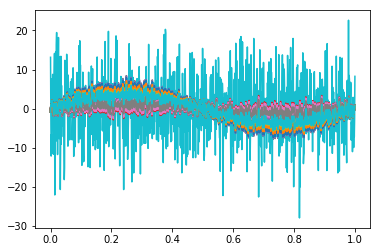

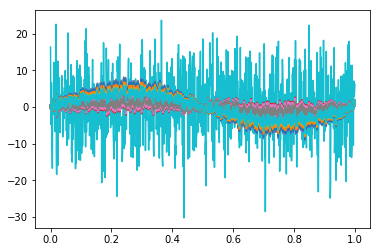

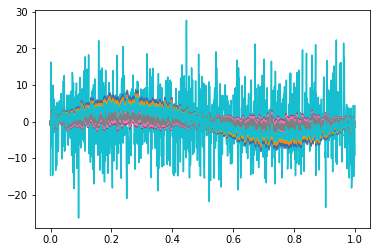

Shapes Equal?: True
Python head
[[-0.72385482  0.50052389  0.98583706 -0.5844848   0.18041448 -1.57344123
   2.17573553 -0.07997344 -0.81163241 -0.06912427]
 [-1.09929466  1.07793154  1.08668387 -0.40162964 -0.86304266 -0.80950696
   1.89166381 -0.09072864 -1.09852183  0.30644516]]
MATLAB Head
[[-0.68670898  0.47483866  0.93524715 -0.55449096  0.17115621 -1.49269741
   2.06408396 -0.07586946 -0.76998211 -0.06557704]
 [-1.04288248  1.02261565  1.03091883 -0.38101933 -0.81875416 -0.76796573
   1.79458986 -0.08607274 -1.04214931  0.29071941]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: False
All electrode/trial rejections the same?: False


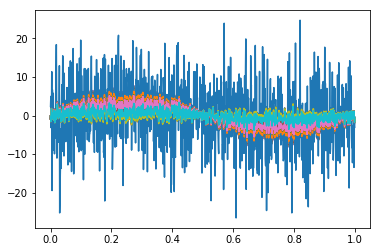

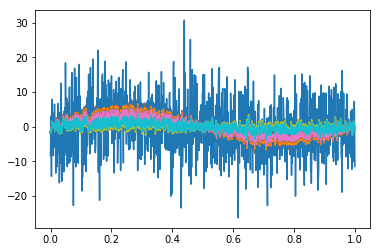

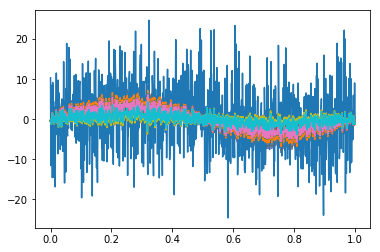

Shapes Equal?: True
Python head
[[-1.15458002  0.99577875 -0.24476748  0.33792206  0.73352743  0.70155071
  -1.82749579 -0.89288825 -0.16758496  1.51853756]
 [-1.71134351  0.00792377  0.60033008  0.40373259  0.29431505 -0.13529501
  -1.85915842 -0.00892783  0.9967059   1.41171737]]
MATLAB Head
[[-1.09533078  0.94467867 -0.23220682  0.32058101  0.69588522  0.66554944
  -1.73371474 -0.84706817 -0.15898505  1.44061122]
 [-1.623523    0.00751715  0.56952312  0.38301437  0.27921177 -0.12835211
  -1.76375254 -0.00846968  0.94555824  1.33927269]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


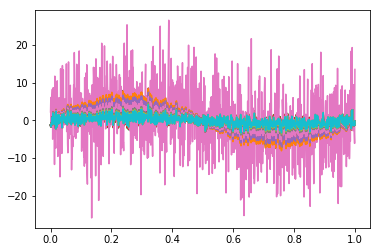

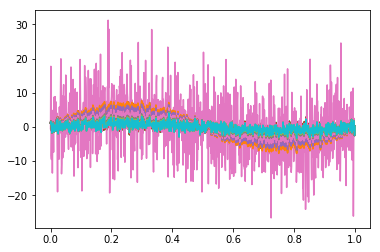

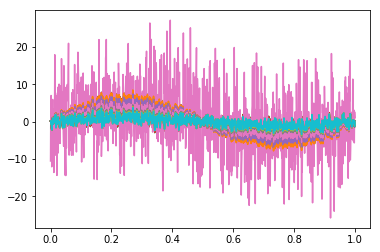

Shapes Equal?: True
Python head
[[-1.8719     -0.78178789  0.83687142  1.33089694  0.43332001  1.04263027
  -0.04251639  0.69073805 -1.21753012 -0.42072229]
 [-1.62620199 -0.83109398  0.66325111  0.38343098  1.85203147  0.50032458
   0.86925034 -0.27953186 -1.20791987 -0.32354079]]
MATLAB Head
[[-1.77584026 -0.74166911  0.79392594  1.2625997   0.41108345  0.98912592
  -0.04033459  0.65529166 -1.15505049 -0.39913221]
 [-1.54275067 -0.78844498  0.62921525  0.36375457  1.75699133  0.47464957
   0.82464328 -0.26518721 -1.1459334  -0.30693774]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


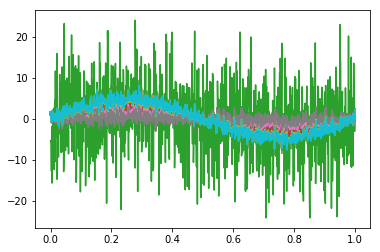

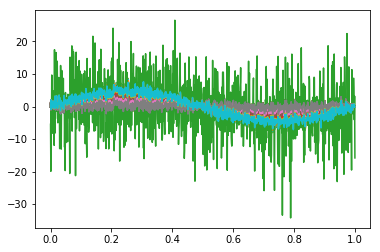

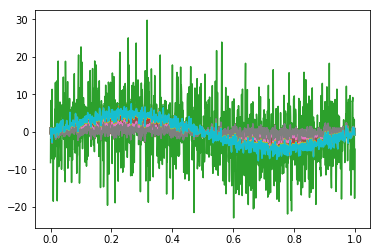

Shapes Equal?: True
Python head
[[ 1.35211023 -1.70453014  1.47799743 -0.76284674 -1.12080289  0.30500493
   0.15360831  0.86171569 -0.61766999  0.05541315]
 [ 0.642954    0.13866617  2.01657995 -0.65311143 -1.15408049 -0.86563669
   0.4771553   0.42875232  0.49671658 -1.52799571]]
MATLAB Head
[[ 1.28272439 -1.61705927  1.40215148 -0.72369996 -1.06328698  0.28935308
   0.14572564  0.81749529 -0.5859732   0.05256953]
 [ 0.60995972  0.13155028  1.91309572 -0.6195959  -1.09485688 -0.82121507
   0.45266926  0.40675016  0.47122672 -1.44958401]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


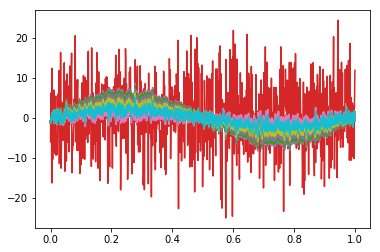

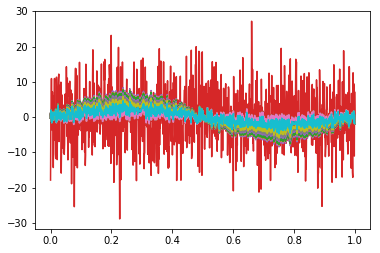

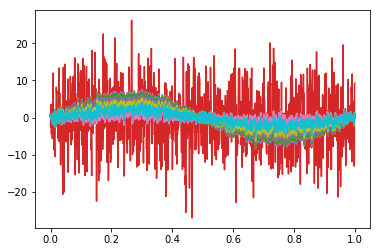

Shapes Equal?: True
Python head
[[ 0.14506078 -0.16113693  0.92134746  0.05501675 -2.60262763  1.24300721
   0.50599848 -0.20071223  0.53773914 -0.44369303]
 [ 0.5312316  -0.35977885 -0.43004494  0.83029856 -2.21340095 -0.45352397
   1.53069298 -0.61813094  0.28739986  0.89525667]]
MATLAB Head
[[ 0.13761674 -0.15286792  0.87406694  0.05219347 -2.46906937  1.17922018
   0.48003231 -0.19041234  0.51014414 -0.42092416]
 [ 0.50397055 -0.34131619 -0.40797646  0.78769037 -2.09981652 -0.43025062
   1.45214287 -0.5864105   0.27265144  0.84931505]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


In [35]:
for i in range(10):
    out = StringIO.StringIO()
    test_dat = success3()
    for j in range(3):
        for k in range(50):
            plt.plot(np.linspace(0,1,1000), test_dat[0][k,j,:])
        plt.show()
    mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
    mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)
    py_jp, py_rej = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)
    mat_jp = np.asarray(mat_jp)
    mat_rej = np.asarray(mat_rej)
    # See results
    print "Shapes Equal?:", py_jp.shape == mat_jp.shape
    print "Python head"
    print py_jp[0:2,:]
    print "MATLAB Head"
    print mat_jp[0:2,:]
    print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))
    print "MATLAB has any NaNs?:", np.isnan(mat_jp).any()
#     print "Python vals bad elec"
#     print py_jp[test_dat[2][0]]
#     print py_rej[0][test_dat[2][0]]
#     print "MATLAB vals bad elec"
#     print mat_jp[test_dat[2][0]]
#     print mat_rej[test_dat[2][0]]
    print "Python has any NaNs?:", np.isnan(py_jp).any()
    print "Arrays close (.1) tolerance?:", np.isclose(py_jp, mat_jp, atol=.1).all()
    print "Badelecs recognized the same?:", np.array_equal(py_rej[0][test_dat[2][0]], mat_rej[test_dat[2][0]])
    print "All electrode/trial rejections the same?:", np.array_equal(py_rej, mat_rej)
    rej_differences = np.logical_xor(py_rej, mat_rej)
    rej_locs = np.where(np.any(rej_differences))

In [9]:
# List all patient names
patient_names = [
    "gp_A00051826001",
    "bip_A00053375001",
    "gip_A00051955001",
    "gip_A00053440001",
    "gip_A00054417001",
    "bip_A00054215001",
    "gip_A00054207001",
    "gp_A00054039001"
]

In [ ]:
incorrect_patients = []
incorrect_elec_patients = []

for name in patient_names:
    out = StringIO.StringIO()
    # get patient data
    patient, time, zero = list(get_patient(name + ".mat")[i] for i in [0, 1, 4])
    # get rid of 0 electrodes
    test_dat = patient[:, list(set(range(111)) - set(zero))]
    # reshape data with trials
    num_trials = 4
    test_dat = trials(test_dat, num_trials)
    for j in range(num_trials):
        for k in range(2):
            plt.plot(time[j * len(time)/num_trials : j * len(time)/num_trials + test_dat.shape[2]], test_dat[k,j,:])
        plt.show()
    mat_test_dat = np.swapaxes(test_dat, 1, 2)
    mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 3, [], 1, 1000.0, nargout = 2, stdout = out)
    py_jp, py_rej, py_unnorm = jointprob(test_dat, [3], np.asarray([]), 1, 1000)
    mat_jp = np.asarray(mat_jp)
    mat_rej = np.asarray(mat_rej)
    # See results
    print name
    print "Shapes Equal?:", py_jp.shape == mat_jp.shape
    print "Python head"
    print py_jp[0:2,:]
    print "MATLAB Head"
    print mat_jp[0:2,:]
    print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))
    print "MATLAB has any NaNs?:", np.isnan(mat_jp).any()
#     print "Python vals bad elec"
#     print py_jp[test_dat[2][0]]
#     print py_rej[0][test_dat[2][0]]
#     print "MATLAB vals bad elec"
#     print mat_jp[test_dat[2][0]]
#     print mat_rej[test_dat[2][0]]
    print "Python has any NaNs?:", np.isnan(py_jp).any()
    print "Arrays close (.1) tolerance?:", np.isclose(py_jp, mat_jp, atol=.1).all()
    if not np.isclose(py_jp, mat_jp, atol=.1).all():
        incorrect_patients.append(name)
#     print "Badelecs recognized the same?:", np.array_equal(py_rej[0][test_dat[2][0]], mat_rej[test_dat[2][0]])
    print "All electrode/trial rejections the same?:", np.array_equal(py_rej, mat_rej)
    if not np.array_equal(py_rej, mat_rej):
        incorrect_elec_patients.append(name)

In [3]:
# Write wrapper pop_jointprob
# inEEG = C x T x N, channels x trials x timepoints, numpy array
# elecrange = range of electrodes, list/numpy array
# locthresh = threshold for individual electrode inspection
# globthresh = threshold for entire dataset inspection
def pop_jointprob(inEEG, elecrange, locthresh, globthresh):
    # first, do localized individual electrode inspection
    jp, rej = jointprob(inEEG[elecrange,:,:], locthresh, 1)
    # now reshape data for global inspection
    globEEG = np.rollaxis(inEEG, 2)
    np.reshape(globEEG, (globEEG.shape[0], globEEG.shape[1] * globEEG.shape[2]))
    # run global inspection
    jpG, rejG = jointprob(globEEG[elecrange,:], globthresh, 1)
    return jp, rej, jpG, rejG

# Write next level wrapper, jointprob
# Joint prob can use different prob functions to get the distribution
# S = C x T x N, channels x trials x timepoints, numpy array
# OR
# S = C x (T x N), timepoints x (channels x trials), numpy array
# OR
# S = (N x C x T), straight vector of all timepoints, numpy array
# thresholds
# norm = choose normalization: 0 = none, 1 = normalize entropy, 2 = 20% trim
# thresh = threshold

def jointprob(S, thresh, oldjp, normalize, discret = 1000):
    # get num chans and trials and time
    channels = 0
    trials = 0
    timepts = 0
    if S.ndim == 1 or S.ndim == 2:
        channels = S.shape[0]
        trials = S.shape[1]
    elif S.ndim == 3:
        channels = S.shape[0]
        trials = S.shape[1]
        timepts = S.shape[2]
    else:
        print "Bad dimensions"
        return
    # Get Joint Probs
    jp = np.zeros((channels, trials))
    if oldjp.size:
        jp = oldjp
    else:
        jp = []
        if S.ndim == 3:
            for c in range(channels):
                tmp, dist = realproba(S[c,:,:], discret)
                jp.append(np.log(tmp))
            jp = np.asarray(jp)
            jp = -np.sum(jp, axis=2)
        elif S.ndim == 2:
            jp, dist = realproba(S[:,:], discret)
            jp = -np.sum(jp, axis=1)
    # Normalize data
    if normalize:
        tmpjp = jp
        if normalize == 2:
            tmpjp = sort(jp);
            totrim = round(len(tmpjp) * 0.1)
            tmpjp = tmpjp[totrim : -totrim]
        if S.ndim == 2:
            jp = (jp - np.mean(tmpjp)) / np.std(tmpjp)
        elif S.ndim == 3:
            ones = np.ones(jp.shape)
            mean = np.mean(jp, axis=1, keepdims=True)
            std = np.std(jp, axis=1, keepdims=True)
            jp = np.divide(jp - mean * ones, std)
    # Reject bad elecs
    rej = []
    for i in thresh:
        rej.append(abs(jp) > i)
    return jp, np.asarray(rej)

# Histogram binning implementation
# D = T x N, D = data Trials, Number of timepts
# b = bins, default 1000
def realproba(D, b = 1000):
    SIZE = D.shape[0] * D.shape[1]
    P = np.zeros(b)
    P_dist = np.zeros(b)
    minimum = np.min(D)
    maximum = np.max(D)
    D = np.floor((D - minimum)/(maximum - minimum) * (b - 1)).astype(int)
    D_flat = np.ndarray.flatten(D)
    for i in range(SIZE):
        P_dist[D_flat[i]] = P_dist[D_flat[i]] + 1
    P = P_dist[D] / SIZE
    P_dist = P_dist / SIZE
    if P_dist.ndim < P.ndim:
        P_dist = np.expand_dims(P_dist, P.ndim - P_dist.ndim)
    return P, P_dist.T